# Data Science Capstone Project

# Introduction
In this project, we will investigate what areas in Stockholm are the most like one area in Gothenburg, where I currently live. Postal codes will be used to define the areas, and data from foursquare will be accessed. The areas will then be clusterd using a Kmeans algorithm to identify areas similar to my current living area.

In [228]:
#Importing libraries
import pandas as pd
import numpy  as np
import re
import requests
from bs4 import BeautifulSoup as bs
import functools
import io
import json
from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
#!conda install -c conda-forge folium=0.5.0 --yes 
import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import pylab
from sklearn.metrics.pairwise import euclidean_distances

# Credentials for APIs
APIKEY = '7d82a34ae444c110070dd93aa647e808eada15a9' #Papilite
CLIENT_ID = 'OEKMEBXITJT02VBZB3LP4ATYZ35OI3PLISMSZUTSJSFMBZQI' # Foursquare 
CLIENT_SECRET = 'POCWPILITAHTRCVJB1EKV1Y1OM30PZXOGVYAPZ4CCPZKHMUQ' # Foursquare   
VERSION = '20180605' # Foursquare
LIMIT = 20 # Foursquare

## Data Collection

In [229]:
# Scraping for the cities within Stockholm
url = "https://www.postnummerservice.se/information/svenska-postnummer-och-postorter/stockholm/stockholm-kommun/"
html_content = requests.get(url).text
soup = bs(html_content, "lxml")
postal_codes_city_odd = soup.find_all("li", attrs={"class": "p5 odd"})
postal_codes_city_even = soup.find_all("li", attrs={"class": "p5 even"})
postal_codes_city = []

for x in postal_codes_city_odd:
    postal_codes_city.append((x.get_text()))
for y in postal_codes_city_even:
    postal_codes_city.append((y.get_text()))
#print(postal_codes)
#print(postal_codes_city)
#len(postal_codes_city)

In [230]:
# Scraping for postal code data and coordinates 
url = "https://www.worldpostalcodes.org/l1/se/se/sverige/karta/r2/karta-over-postnummer-i-stockholms-kommun"
html_content = requests.get(url).text
soup = bs(html_content, "lxml")
# Extracting information
postal_codes_bs = soup.find_all("table", attrs={"class": "table table-striped table-bordered table-hover table-condensed"})
postal_codes_bs = postal_codes_bs[0].find_all("tr")

# Creating empty lists to append to
postal_codes_codes = []
postal_codes_names = []
postal_codes_lat = []
postal_codes_long = []

# extracting and appending data to lists 
for row in postal_codes_bs[2:]:
    a_tag = row.find("a")
    if a_tag is not None:
        # Extract postal code and city name
        postal = str(row.get_text())
        postal_codes_code = postal[:6]
        postal_codes_codes.append(postal_codes_code)
        
        postal_codes_name = postal[6:]
        postal_codes_names.append(postal_codes_name)
        #print(postal_codes_names)
        
        # Extract coordinates
        a_tag_str = str(a_tag)
        coords = a_tag_str[a_tag_str.find('(')+1:a_tag_str.find(')')]
        coords = coords.split(',')
        postal_codes_lat.append(coords[0])
        postal_codes_long.append(coords[1])
        
# creating a dataframe
dict = {'postal code': postal_codes_codes, 'city name': postal_codes_names,'latitude':postal_codes_lat,'longitude':postal_codes_long}
postal_codes_df = pd.DataFrame(dict)

postal_codes_df.replace(to_replace = "", value = np.nan, inplace = True)
postal_codes_df = postal_codes_df.dropna()

# scrape for data current living area
url = "https://www.worldpostalcodes.org/l1/en/se/sweden/profile/postalcode/417-57"
html_content = requests.get(url).text
soup = bs(html_content, "lxml")
#print(soup)

# postal code and name current
title_bs = soup.find('title')
postal_code_current = re.search('\d\d\d\ \d\d',str(title_bs)).group(0)
name_current = re.search('\- .* \-',str(title_bs)).group(0)
name_current = name_current[2:12]

# coordinates current  
find_coords_current = re.search('setView.*',str(soup)).group()
coords_current = re.search("\[.*\]",str(find_coords_current)).group()
lat_current = coords_current[1:12]
long_current = coords_current[13:24] 

# append current to dataframe
dict = {'postal code': postal_code_current, 'city name': name_current,'latitude':lat_current,'longitude':long_current}
current_df = pd.DataFrame(dict, index = [0])
#current_df.head()
postal_codes_df = postal_codes_df.append(current_df).reset_index(drop = True)
postal_codes_df.head()


,postal code,city name,latitude,longitude
0,111 20,Stockholm,59.33230972,18.05678558
1,111 21,Stockholm,59.33220673,18.06044579
2,111 22,Stockholm,59.33369446,18.05535889
3,111 23,Stockholm,59.33536530,18.05177116
4,111 24,Stockholm,59.33652878,18.05361557


In [231]:
# Plottign the data set on map
latitude = postal_codes_df['latitude'].get_value(1)
longitude = postal_codes_df['longitude'].get_value(1) 
#print(latitude,longitude)

m = folium.Map(location=[59.33230972, 18.05678558], zoom_start=11)


# add markers to the map
for lat, long, pc, name in zip(postal_codes_df['latitude'],postal_codes_df['longitude'],postal_codes_df['postal code'],postal_codes_df['city name']):
    folium.Marker(
    location=[float(lat), float(long)],
    popup = folium.Popup(str(pc)+' '+str(name))
).add_to(m)

m

C:\Users\alexg\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\alexg\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [232]:
# Only request Papilite if not in cache
if "cached_requests_get_papilite" not in dir():
    @functools.lru_cache(maxsize=10000)
    def cached_requests_get_papilite(url):
            response = requests.get(url)
            return response

In [233]:
# Function for collecting data from papilite for city
def getPostalCodesCoordinates(city):
    postal_codes_cords=pd.DataFrame() # create empty dataframe

    for POSTORT in city:
        # create the API request URL
        url_papilite = 'https://api.papapi.se/lite/?query={}&format=json&apikey={}'.format(
            POSTORT,
            APIKEY)  
       
        # make the GET request
        response = cached_requests_get_papilite(url=url_papilite)
        
        # load response into dataframe 
        data = json.loads(response.text)
        df_response = json_normalize(data, 'results')
        postal_codes_cords = postal_codes_cords.append(df_response)
    
    return(postal_codes_cords)

In [252]:
# Cleaning up results
postal_codes_cords = getPostalCodesCoordinates(city = postal_codes_city)
postal_codes_cords = postal_codes_cords.loc[postal_codes_cords['county'] == 'Stockholm']
postal_codes_cords = postal_codes_cords.drop(columns=['county_code','county','state_code','state', 'note','updated'])
postal_codes_cords = postal_codes_cords.rename(columns = {'postal_code': 'postal code', 'city': 'city name'})

# add blank space to get postal codes in same format for both data sources
def add_blank_space(x):
    x = x[0:3]+' '+x[3:5]
    return x
    
postal_codes_cords['postal code'] = postal_codes_cords['postal code'].apply(add_blank_space)


print(postal_codes_cords.groupby('city name').count())
postal_codes_cords.head()

                  postal code  latitude  longitude
city name                                         
Bagarmossen                10        10         10
Bandhagen                  34        34         34
Bromma                    100       100        100
Enskede                    29        29         29
Enskede Gård                4         4          4
Enskededalen               16        16         16
Farsta                     35        35         35
Hägersten                  66        66         66
Hässelby                   36        36         36
Johanneshov                33        33         33
Kista                      53        53         53
Skarpnäck                  14        14         14
Skärholmen                 32        32         32
Sköndal                    11        11         11
Spånga                     43        43         43
Stockholm                 100       100        100
Stockholm-Globen            6         6          6
Vällingby                  36  

,postal code,city name,latitude,longitude
0,128 04,Bagarmossen,59.2743878,18.1338486
1,128 05,Bagarmossen,59.2743878,18.1338486
2,128 41,Bagarmossen,59.2788366,18.1253378
3,128 42,Bagarmossen,59.2741368,18.1269813
4,128 43,Bagarmossen,59.2753988,18.1311387


In [235]:
# Plot data from PAP/Lite
latitude = postal_codes_cords['latitude'].get_value(1)
longitude = postal_codes_cords['longitude'].get_value(1) 
#print(latitude,longitude)

m = folium.Map(location=[59.33230972, 18.05678558], zoom_start=11)


# add markers to the map
for lat, long, pc, name in zip(postal_codes_cords['latitude'],postal_codes_cords['longitude'],postal_codes_cords['postal code'],postal_codes_cords['city name']):
    folium.Marker(
    location=[float(lat), float(long)],
    popup = folium.Popup(str(pc)+' '+str(name))
).add_to(m)

m

C:\Users\alexg\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\alexg\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [236]:
#Combining the two data sources

#keeping the data from worldpostalcodes.org but the city names from PAP/Lite
postal_codes_cords = postal_codes_cords.drop(columns=['latitude','longitude'])
postal_codes = postal_codes_df.merge(postal_codes_cords,how='left', on = 'postal code')
postal_codes.drop_duplicates(inplace = True)

postal_codes['city name_y'].fillna(postal_codes['city name_x'], inplace = True)

In [237]:
# put this in a separate cell
postal_codes.drop('city name_x', axis=1, inplace = True)

In [238]:
postal_codes.rename(columns = {'city name_y': 'city'}, inplace = True)
postal_codes = postal_codes[['postal code', 'city', 'latitude', 'longitude']]
postal_codes.groupby('city').count()

,postal code,latitude,longitude
city,,,
Bagarmossen,8,8,8
Bandhagen,29,29,29
Bromma,81,81,81
Djurgården,1,1,1
Enskede,23,23,23
Enskede Gård,2,2,2
Enskededalen,5,5,5
Farsta,26,26,26
Fredhäll,1,1,1


# Calling Foursquare

In [239]:
# Only request Foursquare if not in cache
if "cached_requests_get_foursquare" not in dir():
    @functools.lru_cache(maxsize=10000)
    def cached_requests_get_foursquare(url):
            response = requests.get(url)
            return response

In [240]:
# Get nearby venues from foursquare
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    global venues_list
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        request_json = cached_requests_get_foursquare(url).json()
        results = request_json["response"]['groups'][0]['items']
   
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code',
                  'Postal Code Latitude', 
                  'Postal Code Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [241]:
# Collect information from foursquare, create dummies
postal_codes_venues = getNearbyVenues(names=postal_codes['postal code'],
                                   latitudes=postal_codes['latitude'],
                                   longitudes=postal_codes['longitude']
                                    )
print(postal_codes_venues)

postal_codes_dummies = pd.get_dummies(postal_codes_venues[['Venue Category']], prefix="", prefix_sep="")
postal_codes_dummies.insert(0,'postal code',postal_codes_venues['Postal Code'])

postal_codes_grouped = postal_codes_dummies.groupby(['postal code'],sort=False).sum().reset_index()

postal_codes_merged = postal_codes.merge(postal_codes_grouped,on='postal code', how='outer')

postal_codes_merged.fillna(0,inplace=True)  
print(postal_codes_merged.shape)
postal_codes_merged.head()

      Postal Code Postal Code Latitude Postal Code Longitude  \
0          111 20          59.33230972           18.05678558   
1          111 20          59.33230972           18.05678558   
2          111 20          59.33230972           18.05678558   
3          111 20          59.33230972           18.05678558   
4          111 20          59.33230972           18.05678558   
...           ...                  ...                   ...   
13850      417 57          57.70415115           11.93092442   
13851      417 57          57.70415115           11.93092442   
13852      417 57          57.70415115           11.93092442   
13853      417 57          57.70415115           11.93092442   
13854      417 57          57.70415115           11.93092442   

                               Venue  Venue Latitude  Venue Longitude  \
0                           Frantzén       59.333854        18.058519   
1                               SATS       59.332544        18.060433   
2           

,postal code,city,latitude,longitude,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,Aquarium,...,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Yoga Studio,Zoo Exhibit
0,111 20,Stockholm,59.33230972,18.05678558,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,111 21,Stockholm,59.33220673,18.06044579,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,111 22,Stockholm,59.33369446,18.05535889,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,111 23,Stockholm,59.33536530,18.05177116,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,111 24,Stockholm,59.33652878,18.05361557,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


     Airport Service  Airport Terminal  American Restaurant  Amphitheater  \
0                  0                 0                    0             0   
1                  0                 0                    0             0   
2                  0                 0                    0             0   
3                  0                 0                    0             0   
4                  0                 0                    0             0   
..               ...               ...                  ...           ...   
781                0                 0                    0             0   
782                0                 0                    0             0   
783                0                 0                    0             0   
784                0                 0                    0             0   
785                0                 0                    0             0   

     Antique Shop  Aquarium  Arcade  Art Gallery  Art Museum  \
0          

C:\Users\alexg\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Venue Category,Number of Venues
0,Café,499
1,Pizza Place,441
2,Scandinavian Restaurant,392
3,Bakery,385
4,Grocery Store,308
5,Sushi Restaurant,306
6,Gym / Fitness Center,303
7,Thai Restaurant,269
8,Park,262
9,Hotel,259


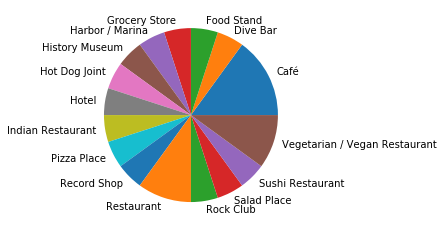

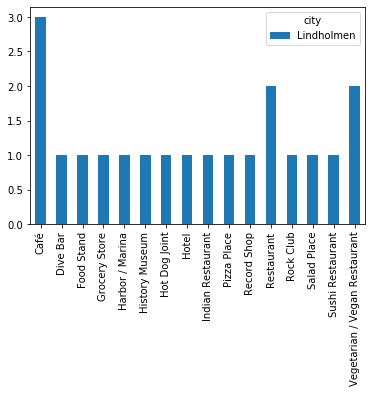

In [254]:
city_venues = postal_codes_merged.groupby(['city'],sort=False).mean().reset_index()

Göteborg = city_venues.loc[city_venues['city']== "Lindholmen"]
Göteborg.replace(to_replace = 0, value = np.nan, inplace = True)
Göteborg.dropna(axis = 1, inplace = True)
Göteborg = Göteborg.set_index('city').transpose()

Göteborg.plot.pie(y='Lindholmen', x='city name', legend=False)
pylab.ylabel('')
Göteborg.plot.bar()

number_of_venues = postal_codes_merged.drop(axis = 0, columns = ['city','postal code','latitude','longitude'])
print(number_of_venues)
number_of_venues = number_of_venues.replace(0,np.nan).count(0)
number_of_venues.sort_values(ascending = False, inplace = True)
number_of_venues_df = pd.DataFrame([number_of_venues]).transpose().reset_index()
number_of_venues_df.columns=['Venue Category', 'Number of Venues']
number_of_venues_df.head(10)

In [243]:
# Prepare current postal code for comparison
print(postal_codes_merged)
current_df = pd.DataFrame(postal_codes_merged.loc[postal_codes_merged['city']=='Lindholmen']).transpose()
current_df.drop(axis = 0, index=['city','postal code','latitude','longitude'], inplace = True)
current_df.replace(to_replace=0,value = np.nan, inplace = True)
current_df.dropna(inplace=True)
current_df.reset_index(inplace= True)
# create empty dataframe for results
num_common_venues = []
num_common_venues = pd.DataFrame(num_common_venues, columns=['postal code','city','in common'])

# prepare and compare with all other postal codes 
for ind in np.arange(postal_codes_merged.shape[0]-1):   
    compare_df = pd.DataFrame(postal_codes_merged.iloc[ind])
    compare_df.drop(axis = 0, index=['city','postal code','latitude','longitude'], inplace = True)
    compare_df.replace(to_replace=0,value = np.nan, inplace = True)
    compare_df.dropna(inplace=True)
    compare_df.reset_index(inplace= True)
    merged_df = compare_df.merge(current_df, how = 'inner', on = 'index')
    
    # add to results dataframe
    to_app = pd.DataFrame(data = {'postal code': [postal_codes_merged['postal code'].iloc[ind]], 
                                  'city': [postal_codes_merged['city'].iloc[ind]],
                                 'in common':[merged_df.shape[0]]})
    num_common_venues = num_common_venues.append(to_app)

max_num_common_venues = num_common_venues.loc[num_common_venues['in common']==max(num_common_venues['in common'])]
max_num_common_venues_group= pd.to_numeric(max_num_common_venues['in common']).groupby([max_num_common_venues.city]).count()

avg_num_common_venues = pd.to_numeric(num_common_venues['in common']).groupby([num_common_venues.city]).mean()
print(avg_num_common_venues)
print(max_num_common_venues)

    postal code        city     latitude    longitude  Airport Service  \
0        111 20   Stockholm  59.33230972  18.05678558                0   
1        111 21   Stockholm  59.33220673  18.06044579                0   
2        111 22   Stockholm  59.33369446  18.05535889                0   
3        111 23   Stockholm  59.33536530  18.05177116                0   
4        111 24   Stockholm  59.33652878  18.05361557                0   
..          ...         ...          ...          ...              ...   
781      168 74      Bromma  59.34543610  17.94752312                0   
782      168 75      Bromma  59.34417725  17.93607140                0   
783      168 76      Bromma  59.33979797  17.93737221                0   
784      168 77      Bromma  59.35898590  17.96167183                0   
785      417 57  Lindholmen  57.70415115  11.93092442                0   

     Airport Terminal  American Restaurant  Amphitheater  Antique Shop  \
0                   0                

In [244]:
# sort in descending order function
def return_most_common_venues(row, num_top_venues):

    row_categories = row.iloc[4:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    zero_indeces = row_categories_sorted == 0
    row_categories_sorted.index.values[zero_indeces] = float('NaN')
    return row_categories_sorted.index.values[0:num_top_venues]

In [255]:
num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['postal code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
print(postal_codes_merged)
postal_codes_venues_sorted = pd.DataFrame(columns=columns)
postal_codes_venues_sorted['postal code'] = postal_codes_merged['postal code']


for ind in np.arange(postal_codes_merged.shape[0]):
    postal_codes_venues_sorted.iloc[ind, 1:] = return_most_common_venues(postal_codes_merged.iloc[ind, :], num_top_venues)
    
postal_codes_venues_sorted.insert(1,'city',postal_codes_merged['city'])
postal_codes_venues_sorted.insert(2,'latitude',postal_codes_merged['latitude'])
postal_codes_venues_sorted.insert(3,'longitude',postal_codes_merged['longitude'])
postal_codes_venues_sorted.shape
print(postal_codes_venues_sorted)
postal_codes_venues_sorted.head()

    postal code        city     latitude    longitude  Airport Service  \
0        111 20   Stockholm  59.33230972  18.05678558                0   
1        111 21   Stockholm  59.33220673  18.06044579                0   
2        111 22   Stockholm  59.33369446  18.05535889                0   
3        111 23   Stockholm  59.33536530  18.05177116                0   
4        111 24   Stockholm  59.33652878  18.05361557                0   
..          ...         ...          ...          ...              ...   
781      168 74      Bromma  59.34543610  17.94752312                0   
782      168 75      Bromma  59.34417725  17.93607140                0   
783      168 76      Bromma  59.33979797  17.93737221                0   
784      168 77      Bromma  59.35898590  17.96167183                0   
785      417 57  Lindholmen  57.70415115  11.93092442                0   

     Airport Terminal  American Restaurant  Amphitheater  Antique Shop  \
0                   0                

,postal code,city,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,...,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,111 20,Stockholm,59.33230972,18.05678558,Café,Hotel,Hostel,Clothing Store,Farmers Market,Seafood Restaurant,...,Sushi Restaurant,Gastropub,Jazz Club,Cocktail Bar,Arts & Crafts Store,Vietnamese Restaurant,Hotel Bar,Gym / Fitness Center,NaN,NaN
1,111 21,Stockholm,59.33220673,18.06044579,Hotel,Café,Scandinavian Restaurant,Arts & Crafts Store,Clothing Store,Cocktail Bar,...,Art Gallery,Hotel Bar,Vietnamese Restaurant,Farmers Market,NaN,NaN,NaN,NaN,NaN,NaN
2,111 22,Stockholm,59.33369446,18.05535889,Hostel,Hotel,Café,Arts & Crafts Store,Jazz Club,Modern European Restaurant,...,Escape Room,Indian Restaurant,Farmers Market,Hotel Bar,Gym / Fitness Center,Vietnamese Restaurant,Taco Place,NaN,NaN,NaN
3,111 23,Stockholm,59.33536530,18.05177116,Scandinavian Restaurant,Hotel,Hostel,South American Restaurant,Modern European Restaurant,Café,...,Jazz Club,Brewery,Indian Restaurant,Vietnamese Restaurant,NaN,NaN,NaN,NaN,NaN,NaN
4,111 24,Stockholm,59.33652878,18.05361557,Scandinavian Restaurant,Hotel,Hostel,Café,Indian Restaurant,Modern European Restaurant,...,South American Restaurant,Vietnamese Restaurant,Coffee Shop,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [257]:
k_scores = []
current_score = []
current_score_cluster = []
all_cluster_labels = pd.DataFrame()
centroids = pd.DataFrame()

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 50):
    kmeans2 = KMeans(n_clusters=k, random_state=1)
    kmeans2.fit(postal_codes_clustering)
    score = silhouette_score(postal_codes_clustering, kmeans2.labels_)
    sample_silhouette_values = silhouette_samples(postal_codes_clustering, kmeans2.labels_)
    cluster_labels= kmeans2.labels_
    all_cluster_labels[k]=cluster_labels
    globals()["euclidian_clusters_" + str(k)] = euclidean_distances(kmeans2.cluster_centers_)
    
    # append metrics
    k_scores.append(score)
    current_score.append(sample_silhouette_values[785])
    current_score_cluster.append(np.mean(sample_silhouette_values[cluster_labels == cluster_labels[785]]))
    


    print(k, " clusters, the avg score is :", score, 
          " Current cluster: ", cluster_labels[785], " with avg score: ", np.mean(sample_silhouette_values[cluster_labels == cluster_labels[785]]))
        
print("max avg score: ", max(k_scores))
print("number of clusters: ", k_scores.index(max(k_scores))+2)
print("max score for curent postal adress: ", max(current_score))
print("number of clusters: ",current_score.index(max(current_score))+2)
print("max avg score for current cluster: ", max(current_score_cluster))
print("number of clusters: ",current_score_cluster.index(max(current_score_cluster))+2)
#print(euclidian_clusters_44)
all_cluster_labels.tail()

2  clusters, the avg score is : 0.07749164207582242  Current cluster:  1  with avg score:  0.009769872441012248
3  clusters, the avg score is : 0.08743209428659171  Current cluster:  0  with avg score:  0.020655080809737745
4  clusters, the avg score is : 0.08669906576486607  Current cluster:  0  with avg score:  0.03552875142996756
5  clusters, the avg score is : 0.08559975609397615  Current cluster:  1  with avg score:  0.04729289651308397
6  clusters, the avg score is : 0.07470936344741066  Current cluster:  1  with avg score:  0.07443939189431747
7  clusters, the avg score is : 0.08277980789256142  Current cluster:  4  with avg score:  0.0849534889933616
8  clusters, the avg score is : 0.08330381851149944  Current cluster:  1  with avg score:  0.057943726707238435
9  clusters, the avg score is : 0.07419028667824648  Current cluster:  3  with avg score:  0.03053140404551278
10  clusters, the avg score is : 0.09176259551567852  Current cluster:  6  with avg score:  0.0304254617633278

,2,3,4,5,6,7,8,9,10,11,...,40,41,42,43,44,45,46,47,48,49
781,0,2,1,3,2,3,4,1,9,0,...,24,2,16,26,33,23,41,26,31,36
782,0,2,1,3,0,3,0,6,9,0,...,24,2,16,26,7,23,41,26,31,36
783,0,2,1,3,2,3,4,1,9,0,...,24,2,16,26,7,23,41,26,31,36
784,1,0,3,1,1,0,1,3,6,7,...,13,40,3,4,26,34,23,21,14,4
785,1,0,0,1,1,4,1,3,6,7,...,15,24,0,36,1,44,19,30,19,12


In [247]:
# add cluster labels to dataframe
postal_codes_clustered_dummies = postal_codes_merged.copy()
postal_codes_clustered = postal_codes_venues_sorted.copy()
postal_codes_clustered_dummies.insert(4,'cluster',all_cluster_labels[44])
postal_codes_clustered.insert(4,'cluster',all_cluster_labels[44])
#postal_codes_clustered.groupby('cluster').count()

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

In [248]:
# Map clusters
#print(postal_codes_clustered)
latitude = float(postal_codes_clustered['latitude'].get_value(1))
longitude = float(postal_codes_clustered['longitude'].get_value(1)) 
#print(latitude,longitude)
#print(type(longitude))
map_clusters = folium.Map(location=[59.33220673, 18.06044579], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters+1)
ys = [i + x + (i*x)**2 for i in range(kclusters+1)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

#print(cluster)
for lat, lon, poi, city, cluster in zip(postal_codes_clustered['latitude'], postal_codes_clustered['longitude'], postal_codes_clustered['postal code'], postal_codes_clustered['city'], postal_codes_clustered['cluster']):
    label = folium.Popup(str(poi) +' '+str(city)+' Cluster ' + str(cluster), parse_html=True)
    #print(lat, lon)
    folium.CircleMarker(
        location = [float(lat), float(lon)],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters

C:\Users\alexg\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\alexg\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


In [250]:
#print(postal_codes_clustered.groupby(postal_codes_clustered['cluster']).count())

# distance matrix
print(euclidian_clusters_44[1])
# Map clusters
latitude = postal_codes_merged['latitude'].get_value(1)
longitude = postal_codes_merged['longitude'].get_value(1) 

map_all = folium.Map(location=[float(latitude), float(longitude)], zoom_start=11)

# add markers to the map
markers_colors = []
current_cluster = postal_codes_clustered.loc[postal_codes_clustered['cluster']== 1]
#print(current_cluster) 
for lat, lon, poi, city in zip(current_cluster['latitude'], current_cluster['longitude'], current_cluster['postal code'], current_cluster['city']):
    label = folium.Popup(str(poi) +' '+str(city), parse_html=True)
    folium.CircleMarker(
        location = [float(lat), float(lon)],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_all)
map_all

#postal_codes_clustered[postal_codes_clustered['cluster']==1].drop(['latitude','longitude'],axis=1).head(30)

[4.87437674 0.         4.08141962 4.03301423 4.03202458 4.21207018
 4.8097291  3.99488334 5.14304699 4.50068819 4.68520129 3.75627048
 4.72847829 4.69282105 5.16086704 4.68893497 4.64036023 3.60262171
 5.17322387 5.38593848 4.46475394 3.78097302 5.67244104 4.66083843
 4.94840255 4.19780035 3.58828224 4.57687424 5.31188395 4.67754684
 4.68735727 4.79924763 4.5301349  4.45571488 4.76176256 4.09575717
 4.34808742 3.75740884 5.3085361  3.12579851 4.64807147 4.95417893
 4.4248666  4.03913907]


C:\Users\alexg\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
C:\Users\alexg\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys
